# 프로젝트 : ResNet Ablation Study

직접 Resnet을 구현하고 모델을 config에 따라 변경 가능하도록 만든 뒤 직접 Ablation 실험을 진행하여 성능을 비교해보는 프로젝트를 시행해보자.

> 참조논문 : <br>1. [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) <br> 2. [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

#### ✔︎ 라이브러리 setting

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [3]:
pip list | grep tensorflow-datasets

tensorflow-datasets           4.0.1


In [4]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## 1. ResNet 기본 블록 구성하기

우선 논문에서 기본적으로 ResNet의 모든 Convolution layer들과 Activation 사이에 Batch Normalization을 사용한다고 쓰여있기 때문에, 그 세 개의 레이어가 하나로 구성되는 Convolution Block을 만들어 주겠다.

In [5]:
def conv_block(input_layer,
               channel,
               kernel_size,
               strides=1,
               activation='relu'):
  
  # input layer
  x = input_layer

  # Convolution layer
  x = keras.layers.Conv2D(filters=channel,
                          kernel_size=kernel_size,
                          kernel_initializer='he_normal',
                          padding='same',
                          strides=strides)(input_layer)

  # BatchNormalization
  x = keras.layers.BatchNormalization()(x)

  # Activation
  if activation:    # Residual Block의 마지막 Conv layer 다음에는 바로 activation이 오지 않으므로 조건을 걸어줌
    x = keras.layers.Activation(activation)(x)
  
  return x

Convolution Block의 기본 구성을 만들었으니 이것을 쌓아서 Residual Block을 만들어준다.
<br>
> ResNet-34의 기본 residual block 구성
1. skip connection 시작
2. 3x3 Conv block 2개
3. skip connection의 끝부분 add
4. Activation<br>
> 
> ResNet-50의 기본 residual block 구성
1. skip connection 시작
2. 1x1 Conv block, 3x3 Conv block, 1x1 Conv block
3. skip connection의 끝부분 add
4. Activation

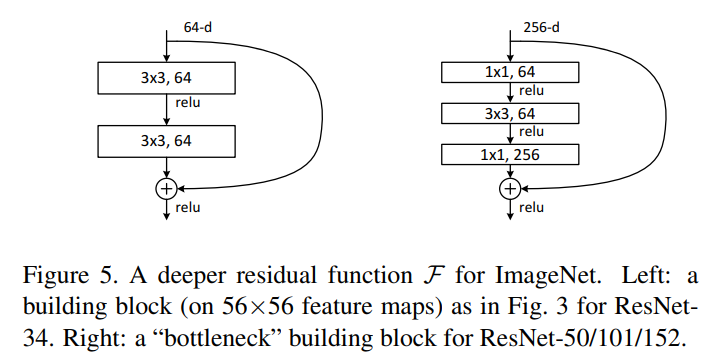

In [6]:
def build_residual_block(input_layer,
                         num_cnn=3,
                         channel=64,
                         block_num=0,
                         is_50=True):
  # 입력 레이어
  x = input_layer

  # ResNet-50
  if is_50:
    for cnn_num in range(num_cnn):
      if cnn_num == 0:  # Block group의 첫번째 block에서는,
        # skip_connection을 통과하면 마지막 Conv layer의 채널값과 같아져야 하므로 channelx4,
        # 첫번째 layer에서는 strides = 2
        skip_connection = conv_block(x, channel*4, (1,1), strides=2, activation=None)
        x = conv_block(x, channel, (1,1), strides = 2)
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel*4, (1,1), activation=None)
      else:
        skip_connection = x  # 이전 블록을 통과한 x는 이미 channel*4가 되어있음
        x = conv_block(x, channel, (1,1))
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel*4, (1,1), activation=None)

      x = keras.layers.Add()([x, skip_connection])
      x = keras.layers.Activation('relu')(x)

  # ResNet-34
  else:
    for cnn_num in range(num_cnn):
      if block_num > 0 and cnn_num == 0:  # Block group의 첫번째 block을 제외한 block들의 첫 layer에서는 strides=2
        skip_connection = conv_block(x, channel, (1,1), strides=2, activation=None)
        x = conv_block(x, channel, (3,3), strides=2)
        x = conv_block(x, channel, (3,3), activation=None)
      else:
        skip_connection = x
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel, (3,3), activation=None)
      
      x = keras.layers.Add()([x, skip_connection])
      x = keras.layers.Activation('relu')(x)
  

  return x



---
## 2. ResNet Complete Model


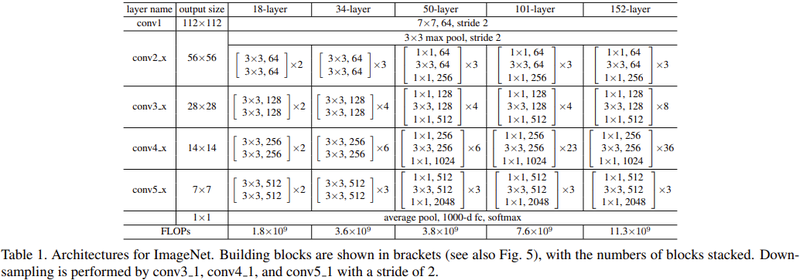

### 1) ResNet 기본 모델 구성
이제 위의 블록들을 쌓아서 기본 모델을 구성해보겠다.

In [7]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 activation='softmax',
                 name='ResNet',
                 is_50=True):
  
  assert len(num_cnn_list) == len(channel_list)  # 모델을 만들기 전에 config list들이 같은 길이인지 확인

  # input layer
  input_layer = keras.layers.Input(shape=input_shape)

  # conv1 layer
  x = conv_block(input_layer, 64, (7,7), strides=2)

  # conv2_x layer의 maxpooling layer
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

  # config list들의 길이만큼 반복해서 Residual Block들을 생성
  for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    x = build_residual_block(x,
                             num_cnn=num_cnn,
                             channel=channel,
                             block_num=block_num,
                             is_50=is_50)
  
  # Global Average Pooling layer
  x = keras.layers.GlobalAveragePooling2D()(x)

  # FC layer
  x = keras.layers.Dense(num_classes,
                         activation=activation,
                         kernel_initializer='he_normal')(x)

  model = keras.Model(inputs=input_layer, outputs=x, name=name)

  return model  

### 2) ResNet-34 Complete Model

In [8]:
resnet_34 = build_resnet(input_shape=(32,32,3), name='ResNet_34', is_50=False)
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][

### 3) ResNet-50 Complete Model

In [9]:
resnet_50 = build_resnet(input_shape=(32,32,3), name='ResNet-50', is_50=True)
resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 16, 16, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 16, 16, 64)  256         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_33 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_36[

---
## 3. 일반 네트워크(plain network) 만들기

### 1) 블록 코드 수정하기
위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용하여 skip connection이 없는 블록을 만들어보자.

In [10]:
def build_plain_block(input_layer,
                         num_cnn=3,
                         channel=64,
                         block_num=0,
                         is_50=True):
  # 입력 레이어
  x = input_layer

  # Plain-50
  if is_50:
    for cnn_num in range(num_cnn):
      if block_num > 0 and cnn_num == 0: 
        x = conv_block(x, channel, (1,1), strides = 2)
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel*4, (1,1))
      else:
        x = conv_block(x, channel, (1,1))
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel*4, (1,1))


  # Plain-34
  else:
    for cnn_num in range(num_cnn):
      if block_num > 0 and cnn_num == 0:
        x = conv_block(x, channel, (3,3), strides=2)
        x = conv_block(x, channel, (3,3))
      else:
        x = conv_block(x, channel, (3,3))
        x = conv_block(x, channel, (3,3))

  return x


### 2) 전체 함수 코드 수정하기

In [11]:
def build_plainnet(input_shape=(224,224,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10,
                 activation='softmax',
                 name='PlainNet',
                 is_50=True):
  
  assert len(num_cnn_list) == len(channel_list)  # 모델을 만들기 전에 config list들이 같은 길이인지 확인

  # input layer
  input_layer = keras.layers.Input(shape=input_shape)

  # conv1 layer
  x = conv_block(input_layer, 64, (7,7), strides=2)

  # conv2_x layer의 maxpooling layer
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)

  # config list들의 길이만큼 반복해서 Residual Block들을 생성
  for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
    x = build_plain_block(x,
                             num_cnn=num_cnn,
                             channel=channel,
                             block_num=block_num,
                             is_50=is_50)
  
  # Global Average Pooling layer
  x = keras.layers.GlobalAveragePooling2D()(x)

  # FC layer
  x = keras.layers.Dense(num_classes,
                         activation=activation,
                         kernel_initializer='he_normal')(x)

  model = keras.Model(inputs=input_layer, outputs=x, name=name)

  return model  

### 3) PlainNet-34 Complete Model

In [12]:
plainnet_34 = build_plainnet(input_shape=(224,224,3), name='PlainNet_34', is_50=False)
plainnet_34.summary()

Model: "PlainNet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        

### 4) PlainNet-50 Complete Model

In [13]:
plainnet_50 = build_plainnet(input_shape=(224,224,3), name='PlainNet_50', is_50=True)
plainnet_50.summary()

Model: "PlainNet_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        

---
## 4. Ablation Study

ResNet-50 vs PlainNet-50
<br> ResNet-34 vs PlainNet-34
<br>에 대해 학습을 진행해보고 결과를 비교해보자.
<br>DataSet은 tensorflow에서 제공하는 ['cats_vs_dogs'](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) 데이터셋을 사용할 예정이다.

### 1) Dataset 준비하기

#### Dataset 불러오기

In [14]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않음

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='/content/drive/MyDrive/AIFFEL/GoingDeeper/GD1/Dataset'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /content/drive/MyDrive/AIFFEL/GoingDeeper/GD1/Dataset/cats_vs_dogs/4.0.0.incomplete893PFS/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /content/drive/MyDrive/AIFFEL/GoingDeeper/GD1/Dataset/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [15]:
# Tensorflow 데이터셋의 feature 정보를 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [16]:
# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


#### Dataset 확인

In [17]:
ds_info.features["label"].num_classes

2

In [18]:
ds_info.features["label"].names

['cat', 'dog']

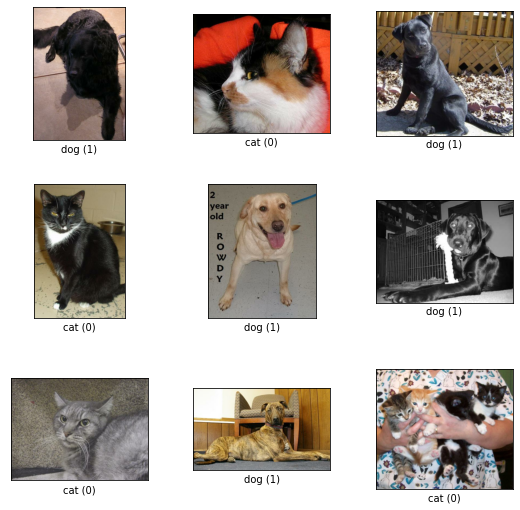

In [19]:
fig = tfds.show_examples(ds_train, ds_info)

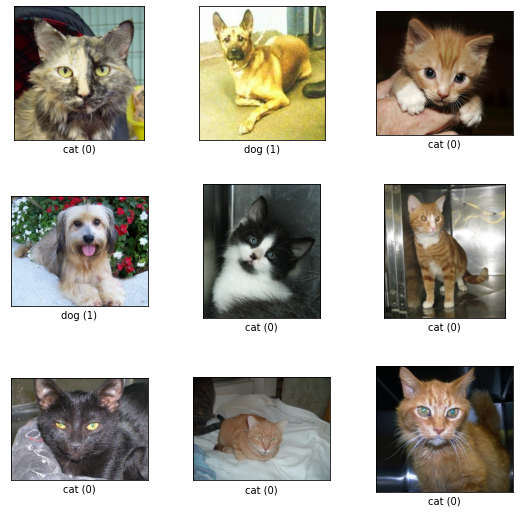

In [20]:
fig = tfds.show_examples(ds_test, ds_info)

#### Dataset Normalization

In [21]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [22]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [23]:
BATCH_SIZE = 32
EPOCH = 15

In [24]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### 2) ResNet-50 vs PlainNet-50

#### ResNet-50

In [25]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         is_50=True,
                         name="ResNet_50",
                         activation='sigmoid', 
                         num_classes=1) # 개와 고양이 이진 분류이므로 활성화 함수 sigmoid로 바꿔줌

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 112, 112, 64  9472        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_171 (Batch  (None, 112, 112, 64  256        ['conv2d_171[0][0]']             
 Normalization)                 )                                                         

In [26]:
resnet_50.compile(
    loss='binary_crossentropy',          # 이진 분류에 알맞은 binary_crossentropy 손실 함수 채택
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 104s 129ms/step - loss: 6.0157 - accuracy: 0.5418 - val_loss: 6.0002 - val_accuracy: 0.5587
Epoch 2/15
581/581 [==============================] - 64s 111ms/step - loss: 6.0001 - accuracy: 0.5585 - val_loss: 5.9999 - val_accuracy: 0.5550
Epoch 3/15
581/581 [==============================] - 64s 111ms/step - loss: 5.9915 - accuracy: 0.5747 - val_loss: 6.0192 - val_accuracy: 0.5407
Epoch 4/15
581/581 [==============================] - 64s 110ms/step - loss: 5.9887 - accuracy: 0.5707 - val_loss: 6.0059 - val_accuracy: 0.5515
Epoch 5/15
581/581 [==============================] - 64s 110ms/step - loss: 5.9843 - accuracy: 0.5832 - val_loss: 5.9854 - val_accuracy: 0.5779
Epoch 6/15
581/581 [==============================] - 64s 111ms/step - loss: 5.9795 - accuracy: 0.5903 - val_loss: 5.9803 - val_accuracy: 0.5688
Epoch 7/15
581/581 [==============================] - 64s 110ms/step - loss: 5.9746 - accuracy: 0.5901 - val_loss: 5.9911 - val_accuracy: 0.

#### PlainNet-50

In [27]:
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         name="PlainNet_50",
                         activation='sigmoid') 

plainnet_50.compile(
    loss='binary_crossentropy',        
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 119s 173ms/step - loss: 5.2319 - accuracy: 0.5445 - val_loss: 5.2339 - val_accuracy: 0.5175
Epoch 2/15
581/581 [==============================] - 99s 171ms/step - loss: 5.2278 - accuracy: 0.5501 - val_loss: 5.2264 - val_accuracy: 0.5468
Epoch 3/15
581/581 [==============================] - 99s 170ms/step - loss: 5.2251 - accuracy: 0.5609 - val_loss: 5.2315 - val_accuracy: 0.5452
Epoch 4/15
581/581 [==============================] - 99s 171ms/step - loss: 5.2251 - accuracy: 0.5535 - val_loss: 5.2256 - val_accuracy: 0.5504
Epoch 5/15
581/581 [==============================] - 99s 171ms/step - loss: 5.2226 - accuracy: 0.5549 - val_loss: 5.2229 - val_accuracy: 0.5644
Epoch 6/15
581/581 [==============================] - 100s 172ms/step - loss: 5.2227 - accuracy: 0.5544 - val_loss: 5.2251 - val_accuracy: 0.5446
Epoch 7/15
581/581 [==============================] - 100s 172ms/step - loss: 5.2200 - accuracy: 0.5587 - val_loss: 5.2226 - val_accuracy: 

### 3) ResNet-34 vs PlainNet-34

#### ResNet-34

In [28]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False,
                         name="ResNet_34",
                         activation='sigmoid') 

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 90s 129ms/step - loss: 2.3870 - accuracy: 0.5807 - val_loss: 2.3795 - val_accuracy: 0.5629
Epoch 2/15
581/581 [==============================] - 74s 127ms/step - loss: 2.3422 - accuracy: 0.6327 - val_loss: 2.3403 - val_accuracy: 0.6431
Epoch 3/15
581/581 [==============================] - 75s 129ms/step - loss: 2.3191 - accuracy: 0.6538 - val_loss: 2.3356 - val_accuracy: 0.6359
Epoch 4/15
581/581 [==============================] - 74s 127ms/step - loss: 2.3022 - accuracy: 0.6746 - val_loss: 2.3218 - val_accuracy: 0.6457
Epoch 5/15
581/581 [==============================] - 74s 127ms/step - loss: 2.2879 - accuracy: 0.6871 - val_loss: 2.3466 - val_accuracy: 0.6303
Epoch 6/15
581/581 [==============================] - 74s 127ms/step - loss: 2.2739 - accuracy: 0.6987 - val_loss: 2.3225 - val_accuracy: 0.6543
Epoch 7/15
581/581 [==============================] - 74s 128ms/step - loss: 2.2546 - accuracy: 0.7198 - val_loss: 2.3219 - val_accuracy: 0.6

#### PlainNet-34

In [29]:
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False,
                         name="PlainNet_34",
                         activation='sigmoid') 

plainnet_34.compile(
    loss='binary_crossentropy',        
    optimizer=tf.keras.optimizers.SGD(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_plainnet_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


581/581 [==============================] - 87s 126ms/step - loss: 2.2190 - accuracy: 0.5519 - val_loss: 2.2017 - val_accuracy: 0.5784
Epoch 2/15
581/581 [==============================] - 72s 124ms/step - loss: 2.1970 - accuracy: 0.5844 - val_loss: 2.2011 - val_accuracy: 0.5885
Epoch 3/15
581/581 [==============================] - 71s 123ms/step - loss: 2.1948 - accuracy: 0.5884 - val_loss: 2.1960 - val_accuracy: 0.5946
Epoch 4/15
581/581 [==============================] - 72s 123ms/step - loss: 2.1923 - accuracy: 0.5926 - val_loss: 2.1940 - val_accuracy: 0.6028
Epoch 5/15
581/581 [==============================] - 71s 123ms/step - loss: 2.1919 - accuracy: 0.5911 - val_loss: 2.1884 - val_accuracy: 0.6181
Epoch 6/15
581/581 [==============================] - 71s 123ms/step - loss: 2.1861 - accuracy: 0.6009 - val_loss: 2.2033 - val_accuracy: 0.6054
Epoch 7/15
581/581 [==============================] - 72s 124ms/step - loss: 2.1855 - accuracy: 0.6022 - val_loss: 2.1775 - val_accuracy: 0.6

### 4) 시각화를 통한 결과 비교

#### ResNet-50 vs PlainNet-50

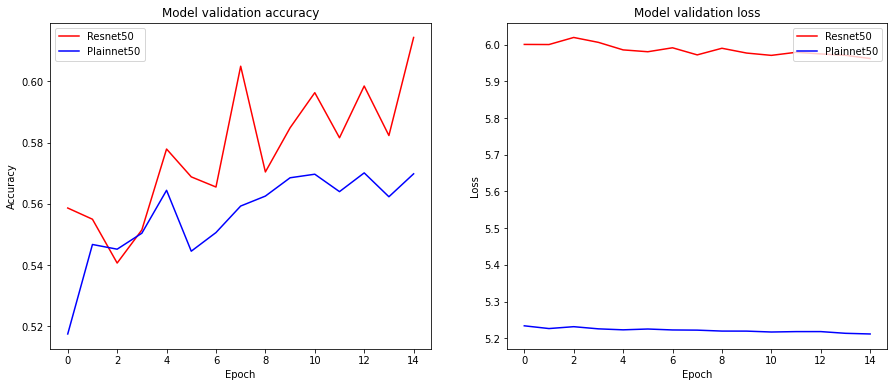

In [30]:
plt.figure(figsize=(15, 6))

# validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plainnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plainnet50'], loc='upper left')

# validation loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plainnet_50.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet50', 'Plainnet50'], loc='upper right')

plt.show()

#### ResNet-34 vs PlainNet-34

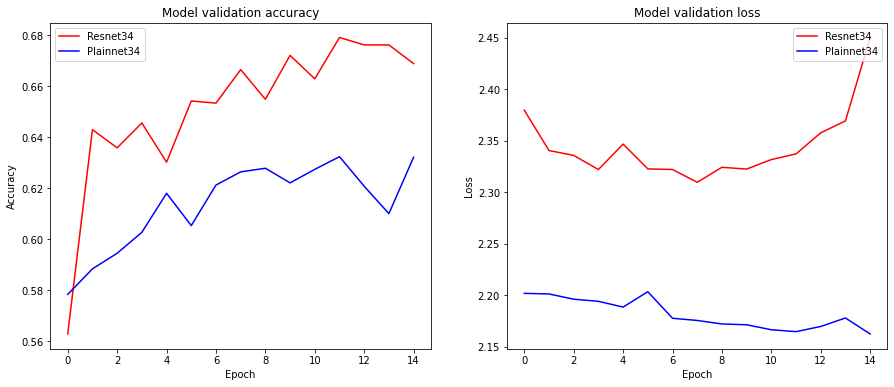

In [40]:
plt.figure(figsize=(15, 6))

# validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plainnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plainnet34'], loc='upper left')

# validation loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_plainnet_34.history['val_loss'], 'b')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet34', 'Plainnet34'], loc='upper right')

plt.show()

## 회고

- 일단 모델을 최선을 다해서 만들었는데, 데이터셋을 이용하여 학습시키니 loss가 제대로 감소하지 않는 느낌이다. 결과만 봐서는 모델을 잘못 만든 느낌인 것 같다. 일단 이렇게 만드는데에 시간도 엄청 오래걸렸는데, 더 시간을 길게 잡고 계속 제대로 된 ResNet을 만들어보려고 노력해봐야겠다.
- Average Pooling layer를 쓰고 Flatten layer와 같이 사용하려고 했는데 사이즈를 줄이는 데에 문제가 생기는 것 같아서 Global Average Pooling layer로 대체했다.
- num_classes 오류가 났는데 원인을 찾아보니 cats_vs_dogs 데이터셋의 input 사이즈를 제대로 입력을 안해줘서 오류가 났다. 항상 주의해야할 부분이다.
- 논문을 코드로 구현하는 경험이 처음인데 정말 어렵고 오래 걸리는 것 같다. 그래도 일단 대충 비슷하게라도 만들어서 다행이라고 생각했는데, 손봐야할 곳이 많은 것 같다. 앞으로 또 여러 논문에 있는 모델 구현을 더 많이 연습해보고 싶다.